# Deploying Flat-Bug

## Flat-bug setup

In [1]:
# Download the test image
from flat_bug import download_from_repository

image = "test_image.jpg"
download_from_repository(image)

# Import the main model class
from flat_bug.predictor import Predictor

# Optionally import the set_log_level function to control the verbosity of flat-bug module
# from flat_bug import set_log_level
# set_log_level("DEBUG") # default is "INFO"

## Basic Usage

In [2]:
# Load the model
model = Predictor(device="cuda:0", dtype="float16")

# Predict
prediction = model(image)

for k, v in prediction.json_data.items():
    v = str(v)
    if len(v) > 100:
        v = v[:100] + "..."
    print(f"{k}: {v}")

YOLOv8m-seg summary (fused): 263 layers, 24,586,035 parameters, 0 gradients, 98.7 GFLOPs
boxes: [[647, 1109, 977, 1277], [914, 1588, 1108, 1804], [2616, 1647, 2768, 1821], [1900, 771, 2021, 919], ...
contours: [[[656.0262451171875, 658.266357421875, 661.62646484375, 664.9866333007812, 668.3467407226562, 672.8...
confs: [0.95751953125, 0.95703125, 0.953125, 0.95068359375, 0.94921875, 0.9482421875, 0.93798828125, 0.9355...
classes: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
scales: [0.5949659166314774, 0.892448874947216, 1.0, 1.0, 1.0, 0.892448874947216, 1.0, 0.892448874947216, 1....
image_path: test_image.jpg
image_width: 3840
image_height: 2160
mask_width: 3840
mask_height: 2160
identifier: None


## Plot results

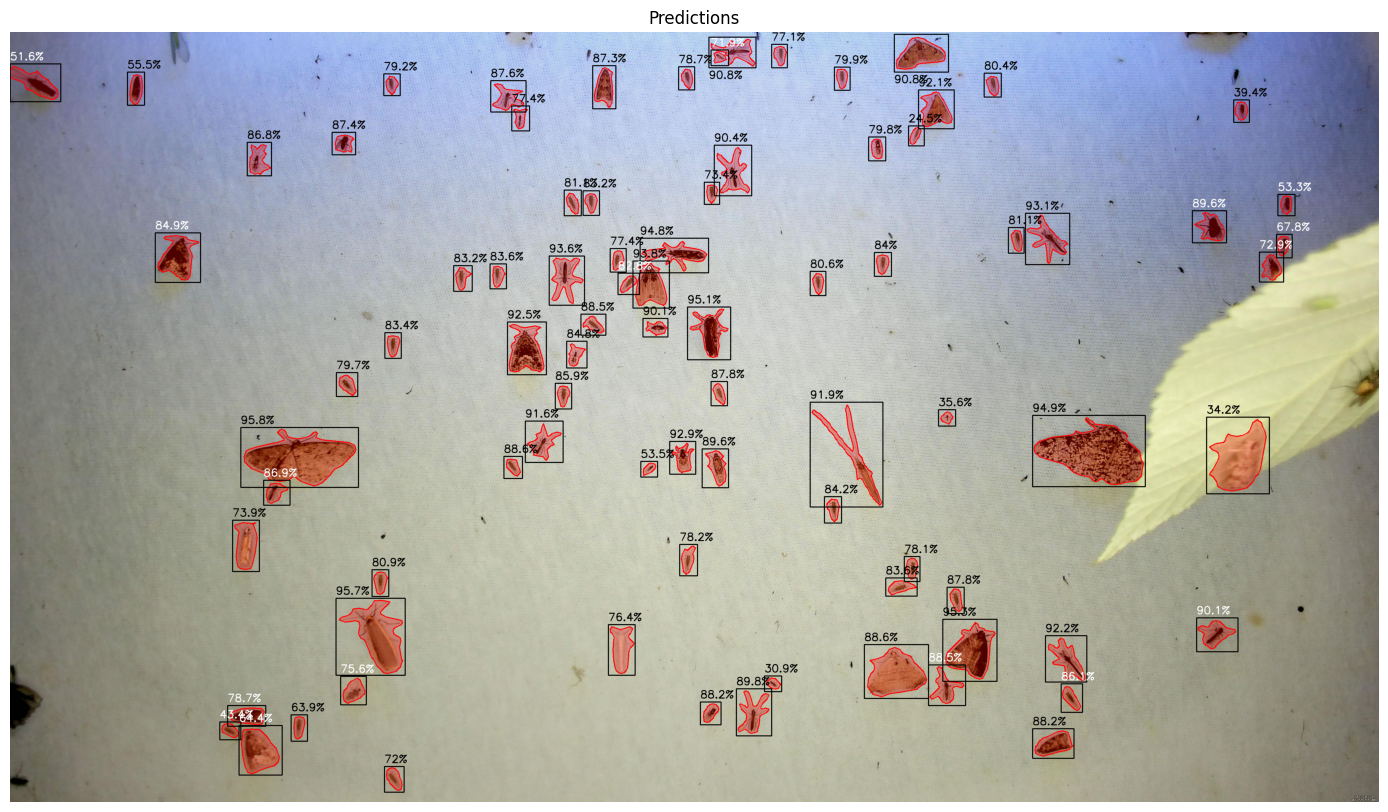

In [3]:
from matplotlib import pyplot as plt

# Plot all the predictions
plt.figure(figsize=(20, 10))
plt.imshow(prediction.plot())
plt.gca().axis("off")
plt.title("Predictions")
plt.show()

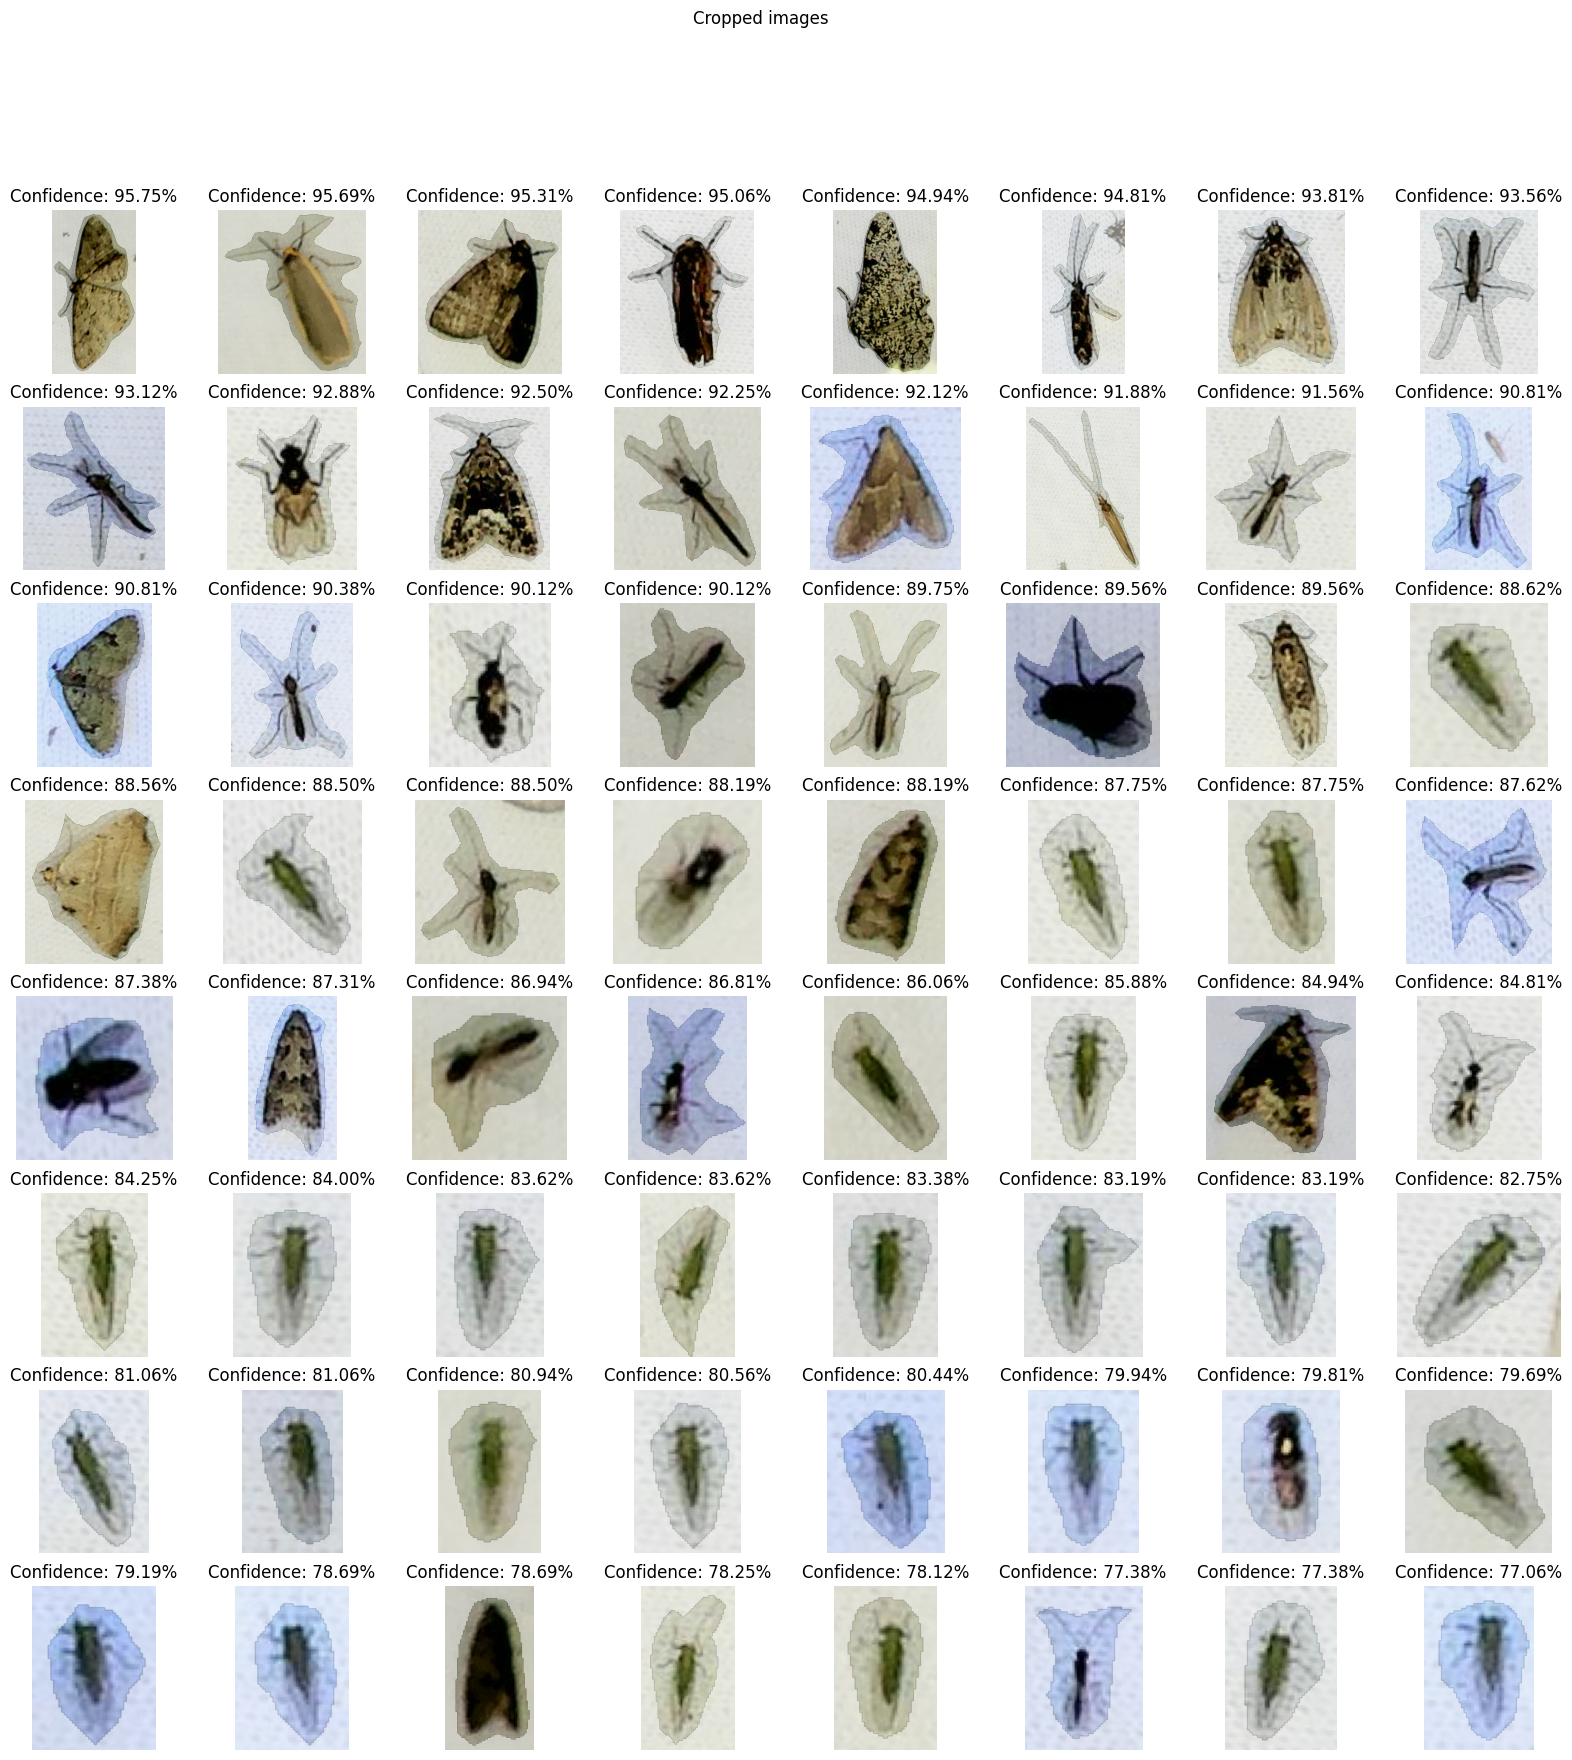

In [4]:
# Plot the cropped images
n_display = min(64, len(prediction))
crops, masks, confidences = prediction.crops[:n_display], prediction.crop_masks[:n_display], prediction.confs[:n_display]

n_crops = len(crops)
ncol = 8
nrow = n_crops // ncol
if n_crops % ncol:
    nrow += 1

fig, axs = plt.subplots(nrow, ncol, figsize=(2.5 * ncol, 2.5 * nrow))
axs = axs.flatten() if n_crops > 1 else [axs]
for ax, crop, mask, conf in zip(axs, crops, masks, confidences):
    crop = crop.permute(1, 2, 0).cpu()
    mask = 1 - mask.squeeze(0).cpu().float()
    w, h = mask.shape
    if w < h:
        mask = mask.transpose(1, 0)
        crop = crop.transpose(1, 0)
    ax.imshow(crop)
    ax.imshow(mask, cmap="gray", vmin=0, vmax=1, alpha=mask * 0.5) 
    ax.set_title(f"Confidence: {conf * 100:.2f}%")
    ax.axis("off")
plt.suptitle("Cropped images")
plt.show()

## Advanced Usage

## Hyperparameters

Timings using the default arguments


2024-11-14 12:14:08 - flat_bug - INFO - Prediction time: 1.000s/86% (overhead: 0.0) | Fetch 2.6% | Forward 75.6% | Postprocess 21.7%)
2024-11-14 12:14:09 - flat_bug - INFO - Prediction time: 0.712s/77.1% (overhead: 0.1) | Fetch 0.1% | Forward 62.3% | Postprocess 37.6%)
2024-11-14 12:14:10 - flat_bug - INFO - Prediction time: 0.448s/74.1% (overhead: 0.1) | Fetch 0.1% | Forward 52.3% | Postprocess 47.6%)
2024-11-14 12:14:10 - flat_bug - INFO - Prediction time: 0.116s/75.3% (overhead: 0.2) | Fetch 0.1% | Forward 45.5% | Postprocess 54.4%)
2024-11-14 12:14:10 - flat_bug - INFO - Prediction time: 0.027s/78.1% (overhead: 0.4) | Fetch 0.2% | Forward 74.3% | Postprocess 25.6%)
2024-11-14 12:14:10 - flat_bug - INFO - Total detection time: 2.879s (52.3% forward)
2024-11-14 12:14:11 - flat_bug - INFO - Combining 5 predictions into a single TensorPredictions object took 0.757 s | Duplication removal: 0.395 s | Mask combination: 0.179 s
2024-11-14 12:14:11 - flat_bug - INFO - Initializing TensorPre

Timings after manually overriding the pyramid_predictions arguments (scale_before=0.5, single_scale=True)


2024-11-14 12:14:13 - flat_bug - INFO - Prediction time: 0.202s/79% (overhead: 0.1) | Fetch 0.1% | Forward 54.7% | Postprocess 45.2%)
2024-11-14 12:14:13 - flat_bug - INFO - Total detection time: 0.256s (43.2% forward)
2024-11-14 12:14:13 - flat_bug - INFO - Combining 1 predictions into a single TensorPredictions object took 0.076 s | Duplication removal: 0.040 s | Mask combination: 0.023 s
2024-11-14 12:14:13 - flat_bug - INFO - Initializing TensorPredictions took 0.078 s
2024-11-14 12:14:13 - flat_bug - INFO - Offsetting, scaling and padding took 0.004 s
2024-11-14 12:14:13 - flat_bug - INFO - Non-maximum suppression took 0.067s for removing 30 elements of 66 elements
2024-11-14 12:14:13 - flat_bug - INFO - Total pyramid time: 0.515s (49.7% detection | 21.5% forward)


Timings after manually overriding the pyramid_predictions arguments (scale_before=0.5, single_scale=False)


2024-11-14 12:14:14 - flat_bug - INFO - Prediction time: 0.354s/76.9% (overhead: 0.1) | Fetch 0.2% | Forward 47.9% | Postprocess 51.9%)
2024-11-14 12:14:14 - flat_bug - INFO - Prediction time: 0.122s/74.9% (overhead: 0.1) | Fetch 0.1% | Forward 43.0% | Postprocess 56.9%)
2024-11-14 12:14:14 - flat_bug - INFO - Prediction time: 0.030s/83.2% (overhead: 0.4) | Fetch 0.1% | Forward 64.9% | Postprocess 34.9%)
2024-11-14 12:14:14 - flat_bug - INFO - Total detection time: 0.660s (36.6% forward)
2024-11-14 12:14:14 - flat_bug - INFO - Combining 3 predictions into a single TensorPredictions object took 0.209 s | Duplication removal: 0.115 s | Mask combination: 0.036 s
2024-11-14 12:14:14 - flat_bug - INFO - Initializing TensorPredictions took 0.210 s
2024-11-14 12:14:14 - flat_bug - INFO - Offsetting, scaling and padding took 0.012 s
2024-11-14 12:14:15 - flat_bug - INFO - Non-maximum suppression took 0.216s for removing 199 elements of 241 elements
2024-11-14 12:14:15 - flat_bug - INFO - Total

Timings after manually overriding the pyramid_predictions arguments (scale_before=0.266, single_scale=False)


2024-11-14 12:14:16 - flat_bug - INFO - Non-maximum suppression took 0.243s for removing 9 elements of 22 elements
2024-11-14 12:14:16 - flat_bug - INFO - Total pyramid time: 0.427s (25.7% detection | 19.6% forward)


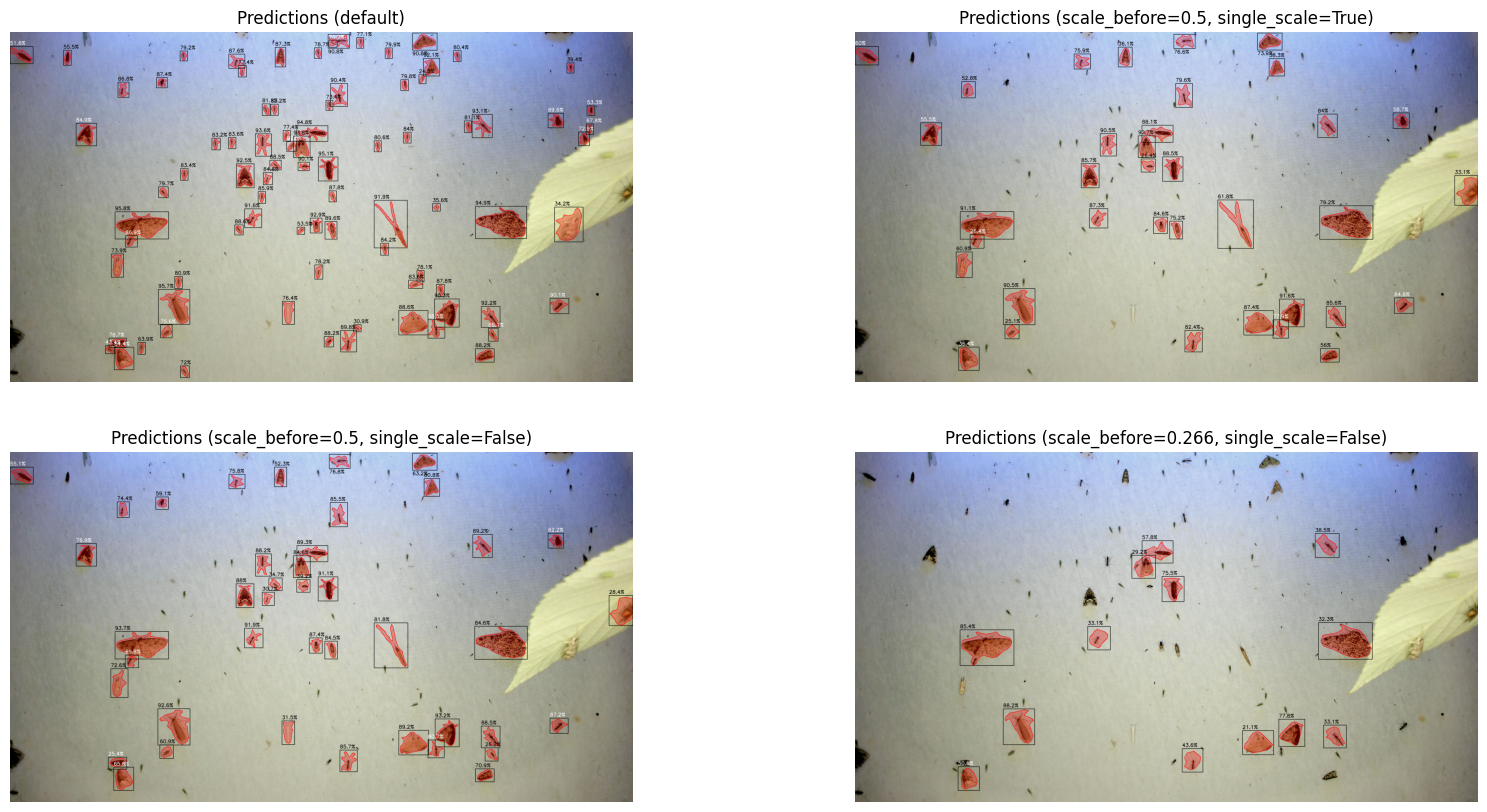

In [5]:
# We can set the model hyperparameters after loading the model with the set_hyperparameters method
model.set_hyperparameters(
    TIME = True,
    # IOU_THRESHOLD, etc. see the documentation for more options
)

# Here I will demonstrate how to use the pyramid_predictions method with custom arguments and compare the timings and results
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.flatten()

# Predict with defaults
print("Timings using the default arguments")
axs[0].imshow(model.pyramid_predictions(image).plot()) # Default arguments (scale_before=1.0, single_scale=False)
axs[0].axis("off")
axs[0].set_title("Predictions (default)")

# Predict with custom arguments
print("Timings after manually overriding the pyramid_predictions arguments (scale_before=0.5, single_scale=True)")
axs[1].imshow(model.pyramid_predictions(image, scale_before=0.5, single_scale=True).plot()) # Scale the image down by 50% and only predict at the native level
axs[1].axis("off")
axs[1].set_title("Predictions (scale_before=0.5, single_scale=True)")

print("Timings after manually overriding the pyramid_predictions arguments (scale_before=0.5, single_scale=False)")
axs[2].imshow(model.pyramid_predictions(image, scale_before=0.5, single_scale=False).plot()) # Scale the image down by 50% and tile from there
axs[2].axis("off")
axs[2].set_title("Predictions (scale_before=0.5, single_scale=False)")

print("Timings after manually overriding the pyramid_predictions arguments (scale_before=0.266, single_scale=False)") # Scale the image down such that the largest dimension is smaller than the tile size (1024)
axs[3].imshow(model.pyramid_predictions(image, scale_before=0.266, single_scale=False).plot()) # Scale the image down such that the largest dimension is smaller than the tile size (1024)
axs[3].axis("off")
axs[3].set_title("Predictions (scale_before=0.266, single_scale=False)")

# Show plot
plt.show()